In [1]:
import pandas as pd
import numpy as np
import holoviews as hv
hv.notebook_extension()
%matplotlib inline

wargame = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/wargame-data/master/data/510064564/final_data.csv", index_col=0)
wargame = wargame.drop(['Salves', 'SalvoIsMainSalvo'], axis='columns')

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,12,27,42,43,48,63,77,78,90,110,113,117,118,130,150,153,283,284,298,318,321,325,326,340,360,363,367,368,382,402,405,409,410,422,442,445,449,450,464,484,487,491,492,504,524,527) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are a variety of factors that one must take into account when evaluating the performance of a tank in WRD. One litmus test that you can use is to ask how much AV your tank must have in order to guarantee that it will survive getting hit by an opposing tank costing N or less, at various ranges.

This notebook builds a `holoviews` interactive that answers this question.

In [2]:
redfor_nations = ['Czechoslavakia', 'Poland', 'Soviet Union', 'Finland', 'East Germany', 'North Korea',
                  'China', 'Yugoslavia']

In [3]:
redfor_min_av_costs = np.maximum.accumulate(
    wargame
        .query('Tab == "TNK"')
        .query('MotherCountry in @redfor_nations')
        .groupby('ArmorFront')
        ['Price']
        .agg(np.min)
        .pipe(lambda df: df.reindex(range(1, df.index[-1] + 1)))
        .fillna(method='backfill')
)

In [4]:
redfor_min_av_costs

ArmorFront
1      15.0
2      15.0
3      15.0
4      20.0
5      20.0
6      25.0
7      25.0
8      25.0
9      40.0
10     40.0
11     45.0
12     55.0
13     55.0
14     75.0
15     85.0
16     90.0
17    110.0
18    110.0
19    140.0
20    140.0
21    160.0
22    170.0
Name: Price, dtype: float64

In [5]:
blufor_min_av_costs = np.maximum.accumulate(
    wargame
        .query('Tab == "TNK"')
        .query('MotherCountry not in @redfor_nations')
        .groupby('ArmorFront')
        ['Price']
        .agg(np.min)
        .pipe(lambda df: df.reindex(range(1, df.index[-1] + 1)))
        .fillna(method='backfill')
)

In [6]:
redfor_min_ap_costs = np.maximum.accumulate(
    wargame
        .query('Tab == "TNK"')
        .query('MotherCountry in @redfor_nations')
        .groupby('Weapon1AP')
        ['Price']
        .agg(np.min)
        .pipe(lambda df: df.reindex(range(1, int(df.index[-1]) + 1)))
        .fillna(method='backfill')
)

In [7]:
blufor_min_ap_costs = np.maximum.accumulate(
    wargame
        .query('Tab == "TNK"')
        .query('MotherCountry not in @redfor_nations')
        .groupby('Weapon1AP')
        ['Price']
        .agg(np.min)
        .pipe(lambda df: df.reindex(range(1, int(df.index[-1]) + 1)))
        .fillna(method='backfill')
)

In [8]:
blufor_min_ap_costs.loc[blufor_min_ap_costs >= 160]

Weapon1AP
24    180.0
Name: Price, dtype: float64

In [9]:
(20 - 10) / 2 + 1

6.0

In [10]:
def av_needed_to_resist(cost=160, opfor='blufor', range=2275):
    if opfor == 'redfor':
        try:
            ap = redfor_min_ap_costs.loc[redfor_min_ap_costs >= cost].index[0]
        except IndexError:  # we exceeded the max(min(ap))
            ap = redfor_min_ap_costs.index[-1]
    else:
        try:
            ap = blufor_min_ap_costs.loc[blufor_min_ap_costs >= cost].index[0]
        except IndexError:  # we exceeded the max(min(ap))
            ap = blufor_min_ap_costs.index[-1]
    
    bonus_ap = 13 - range // 175
    ap += bonus_ap
    
    av_needed_to_resist = ap - 17
    return av_needed_to_resist

In [11]:
180 - 10 / 5

178.0

In [12]:
def avs_needed_to_resist(range=2275, opfor='blufor'):
    avs = [av_needed_to_resist(opfor=opfor, range=range, cost=int(c))\
               for c in np.linspace(10, 180, int(((180 - 10) / 5) + 1))]
    avs = list(map(lambda v: v if v > 0 else 1, avs))
    return list(zip(np.linspace(10, 180, int(((180 - 10) / 5) + 1)), avs))

In [13]:
avs_needed_to_resist()

[(10.0, 1),
 (15.0, 1),
 (20.0, 1),
 (25.0, 1),
 (30.0, 1),
 (35.0, 1),
 (40.0, 1),
 (45.0, 1),
 (50.0, 1),
 (55.0, 1),
 (60.0, 1),
 (65.0, 1),
 (70.0, 1),
 (75.0, 2),
 (80.0, 2),
 (85.0, 3),
 (90.0, 3),
 (95.0, 3),
 (100.0, 3),
 (105.0, 3),
 (110.0, 3),
 (115.0, 3),
 (120.0, 3),
 (125.0, 3),
 (130.0, 3),
 (135.0, 3),
 (140.0, 3),
 (145.0, 4),
 (150.0, 6),
 (155.0, 6),
 (160.0, 7),
 (165.0, 7),
 (170.0, 7),
 (175.0, 7),
 (180.0, 7)]

b':Scatter   [x]   (y)'
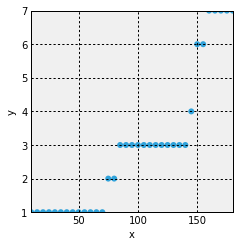

In [154]:
hv.Scatter(avs_needed_to_resist())

In [226]:
avs_needed_to_resist(range=1250)

[(10.0, 1),
 (15.0, 1),
 (20.0, 1),
 (25.0, 1),
 (30.0, 1),
 (35.0, 1),
 (40.0, 3),
 (45.0, 3),
 (50.0, 7),
 (55.0, 7),
 (60.0, 7),
 (65.0, 7),
 (70.0, 7),
 (75.0, 8),
 (80.0, 8),
 (85.0, 9),
 (90.0, 9),
 (95.0, 9),
 (100.0, 9),
 (105.0, 9),
 (110.0, 9),
 (115.0, 9),
 (120.0, 9),
 (125.0, 9),
 (130.0, 9),
 (135.0, 9),
 (140.0, 9),
 (145.0, 10),
 (150.0, 12),
 (155.0, 12),
 (160.0, 13),
 (165.0, 13),
 (170.0, 13),
 (175.0, 13),
 (180.0, 13)]

In [296]:
%%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=5 xticks=list(zip(np.linspace(180, 0, 37), np.linspace(180, 0, 37).astype(int))), xrotation=45] Scatter [show_grid=False]

resist = [(
            (dist), 
            (
                hv.Scatter(hv.Table(avs_needed_to_resist(range=dist), 
                                    kdims=['Cost'], 
                                    vdims=['AV Needed']), 
                           extents=(-5, -1, 185, 20.5))(style={'color': 'steelblue'}) *
                hv.Curve(avs_needed_to_resist(range=dist))(style={'color': 'lightsteelblue'})
            )
          ) for dist in np.linspace(2275, 0, 14)]

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use s

b':HoloMap   [Range to Target]\n   :Overlay\n      .Scatter.I :Scatter   [Cost]   (AV Needed)\n      .Curve.I   :Curve   [x]   (y)'
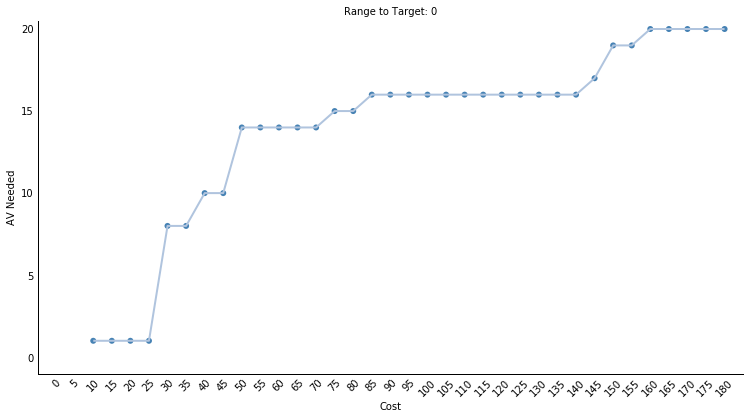
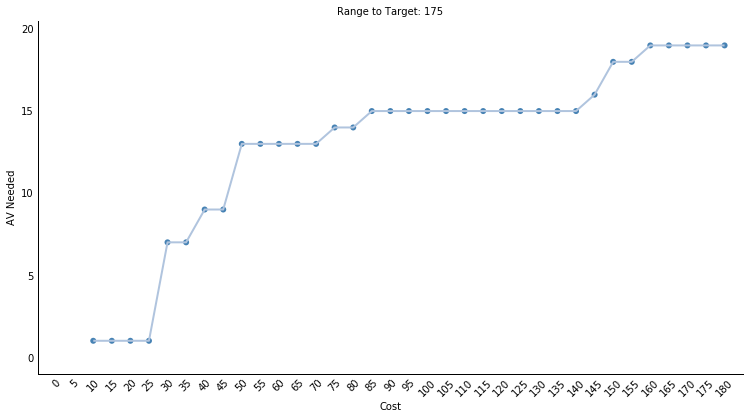
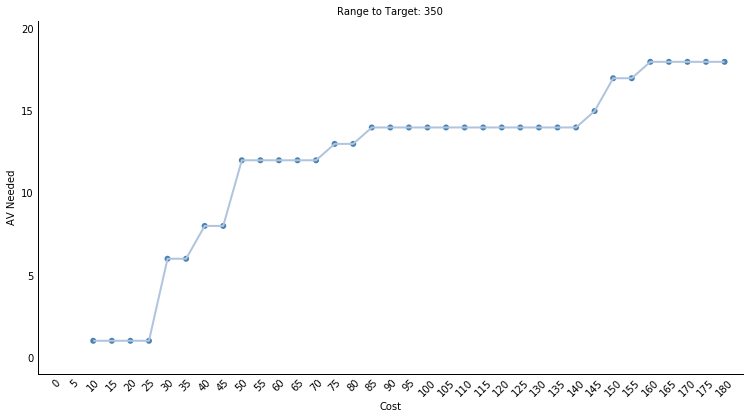
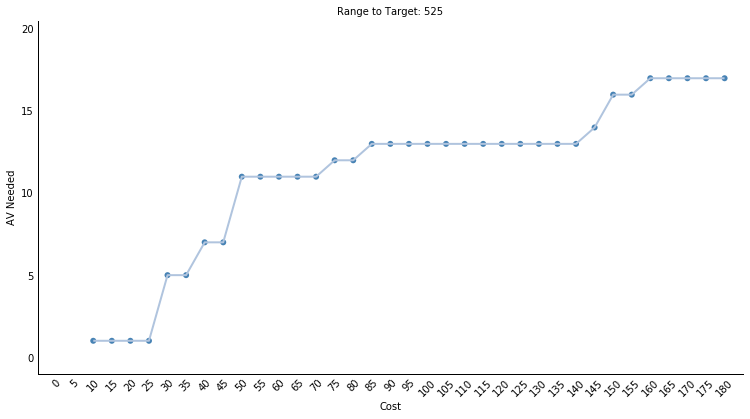
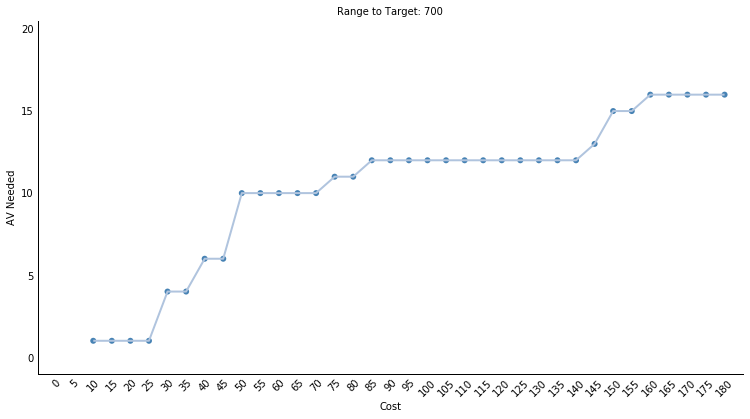
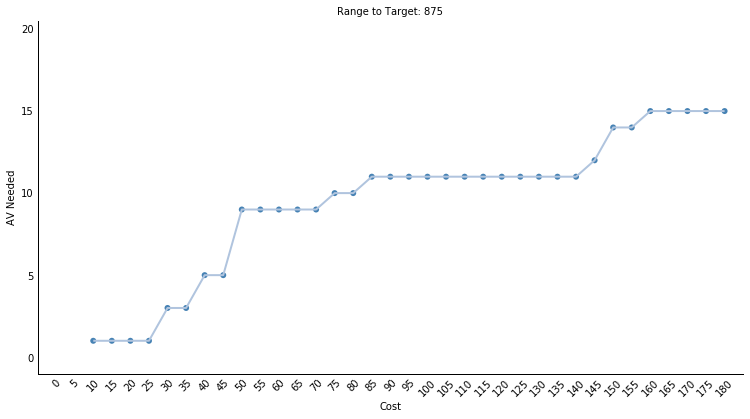
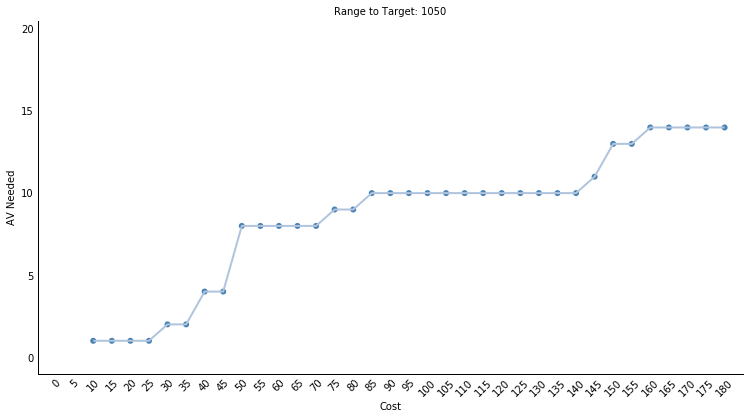
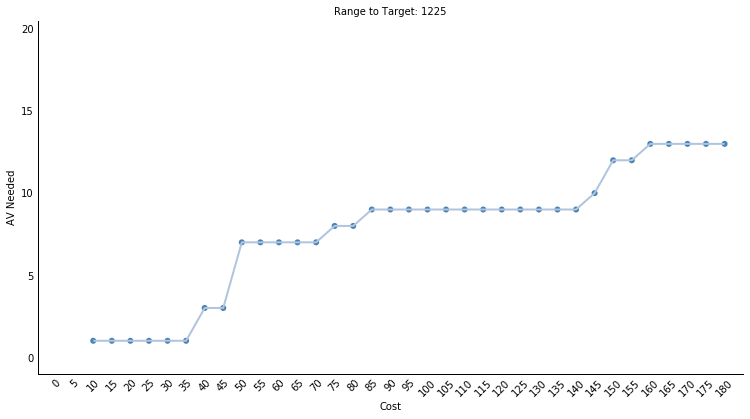
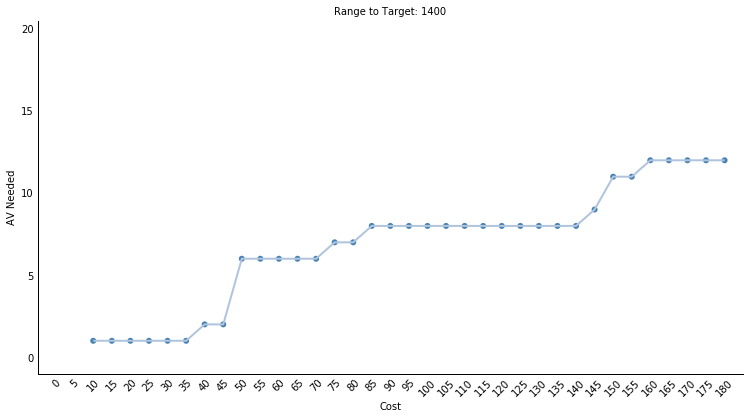
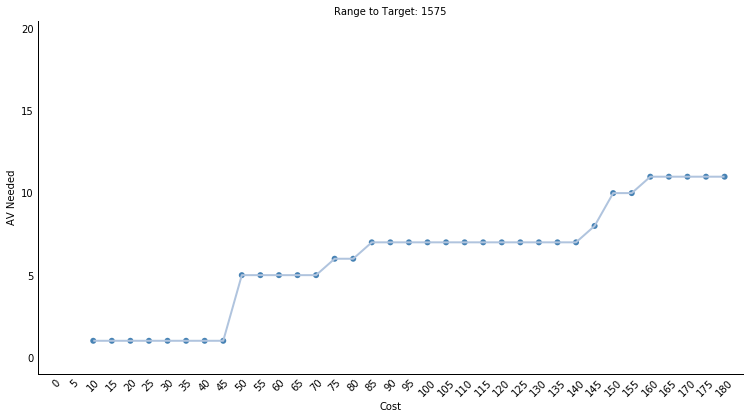
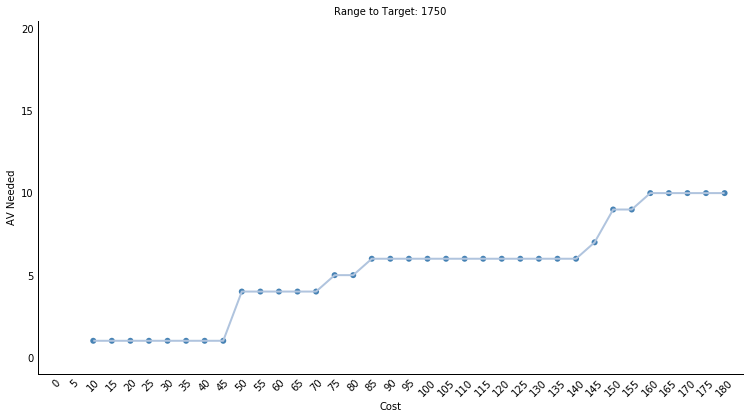
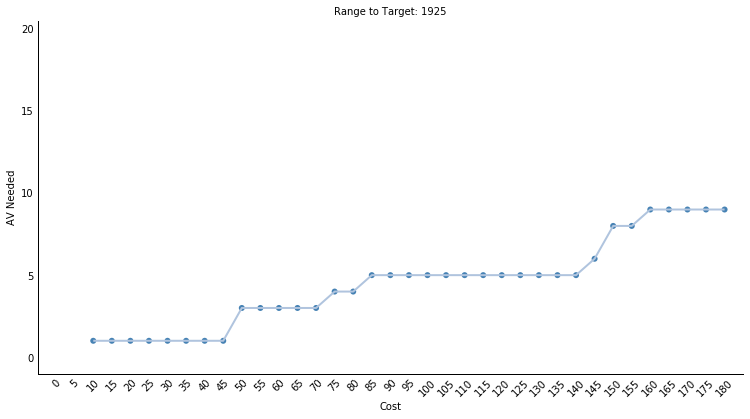
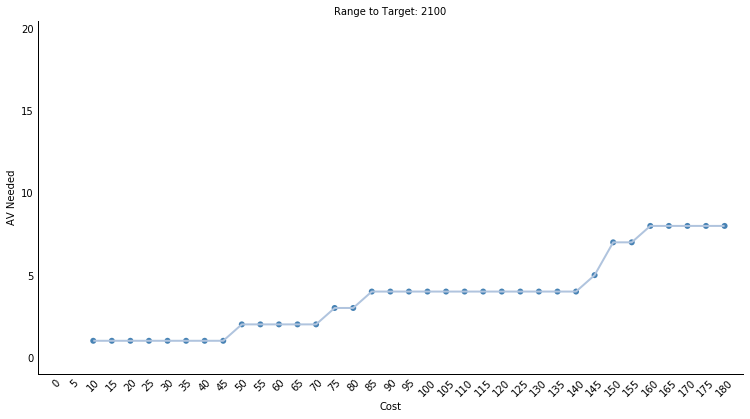
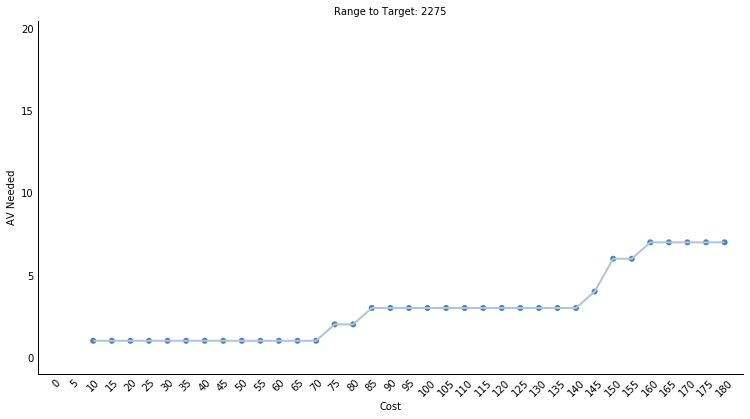

In [297]:
hv.HoloMap(resist, kdims=['Range to Target'])

In [316]:
%%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=5 xticks=list(zip(np.linspace(180, 0, 37), np.linspace(180, 0, 37).astype(int))), xrotation=45] Scatter [show_grid=False]

blu_resist = [(
            (dist), 
            (
                hv.Curve(hv.Table(avs_needed_to_resist(range=dist), 
                                    kdims=['Cost'], 
                                    vdims=['AV Needed']), 
                        extents=(-5, -1, 185, 20.5))(style={'color': 'lightgray', 'linewidth': 5}) *
                hv.Scatter(avs_needed_to_resist(range=dist))(style={'color': 'steelblue', 's': 100})              
            )
          ) for dist in np.linspace(2275, 0, 14)]

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use s

b':HoloMap   [Range to Target]\n   :Overlay\n      .Curve.I   :Curve   [Cost]   (AV Needed)\n      .Scatter.I :Scatter   [x]   (y)'
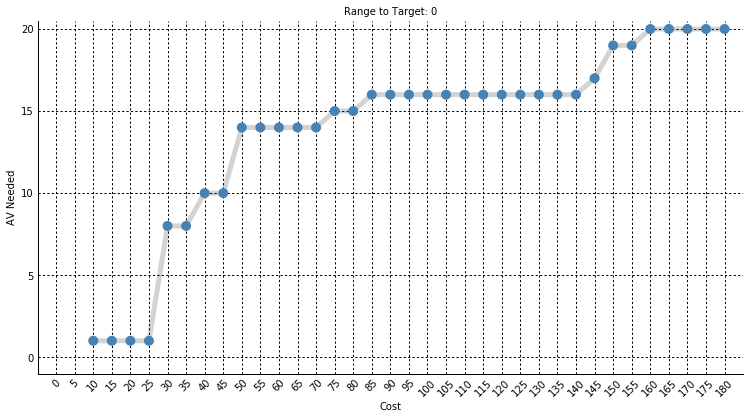
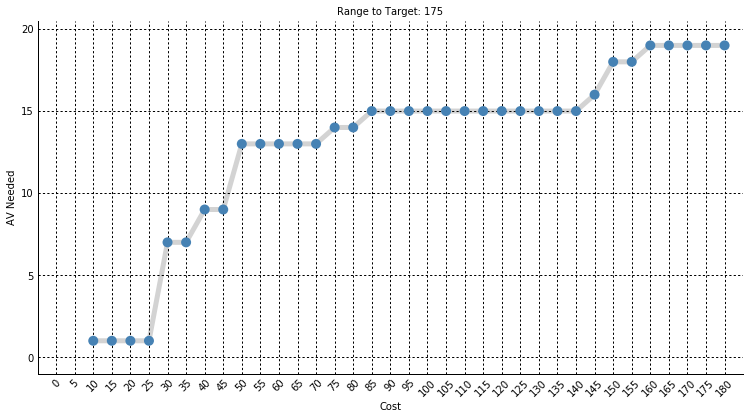
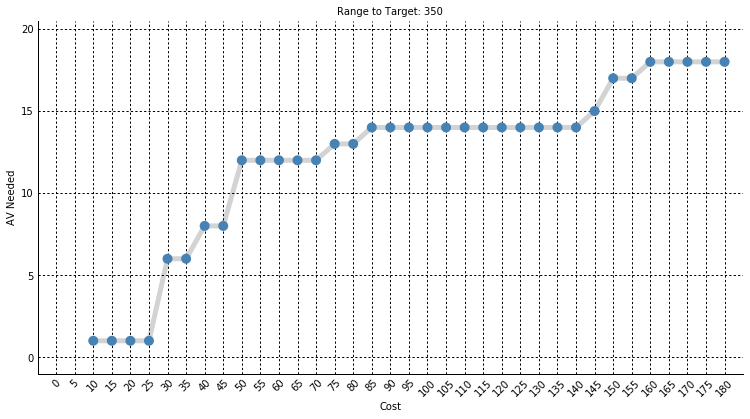
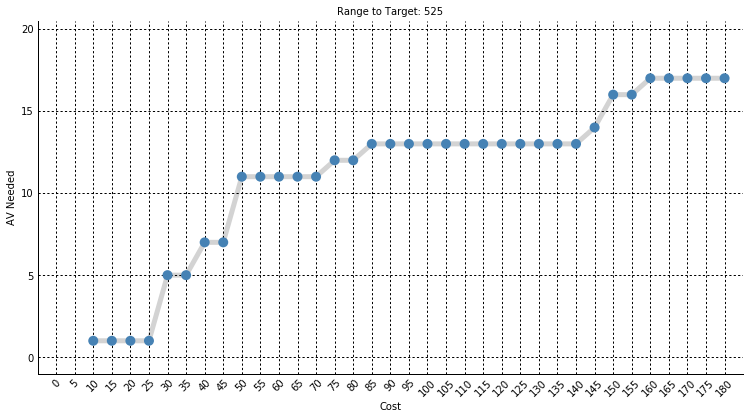
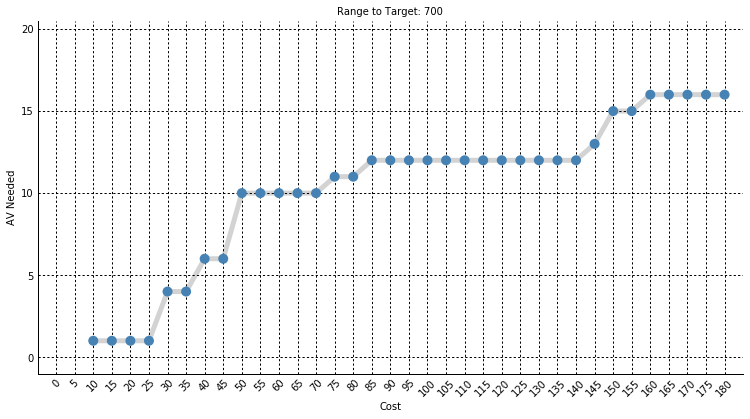
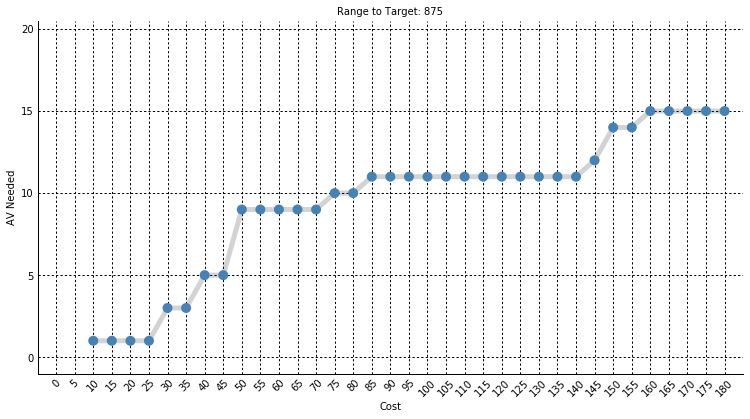
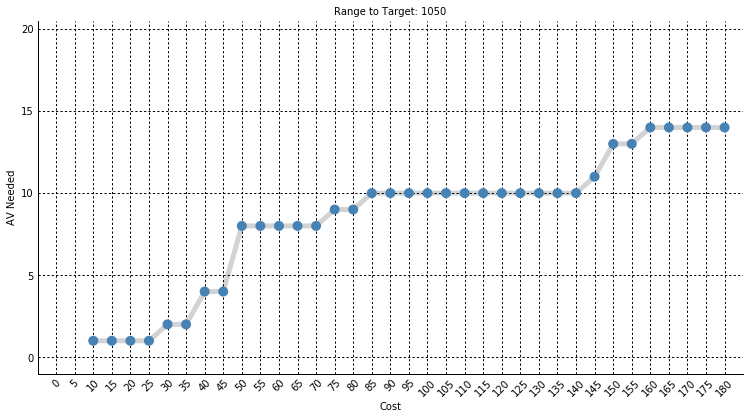
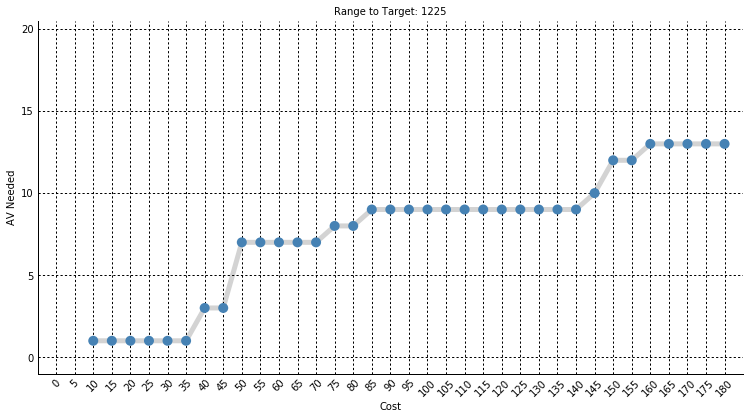
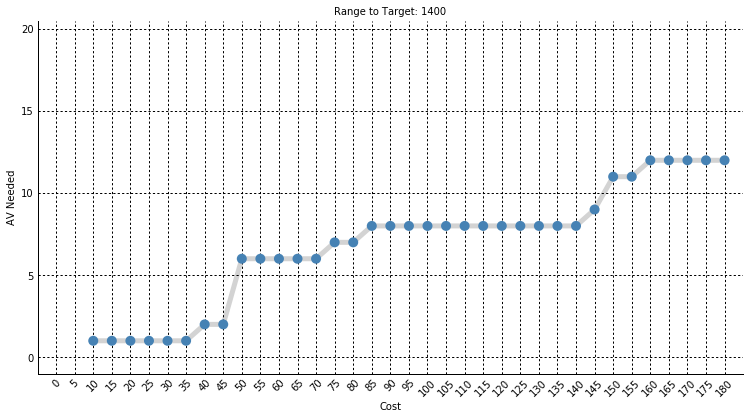
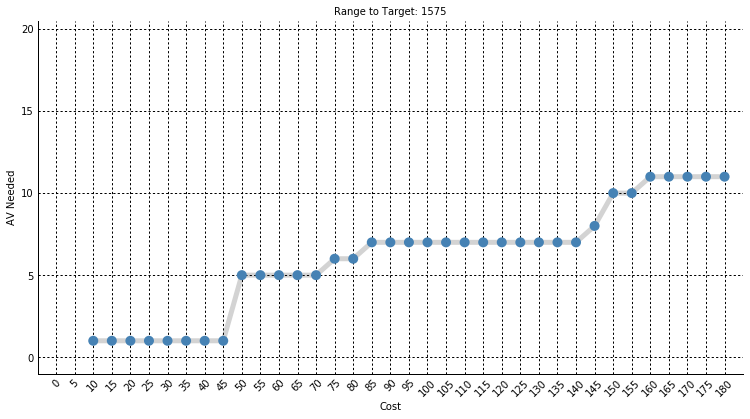
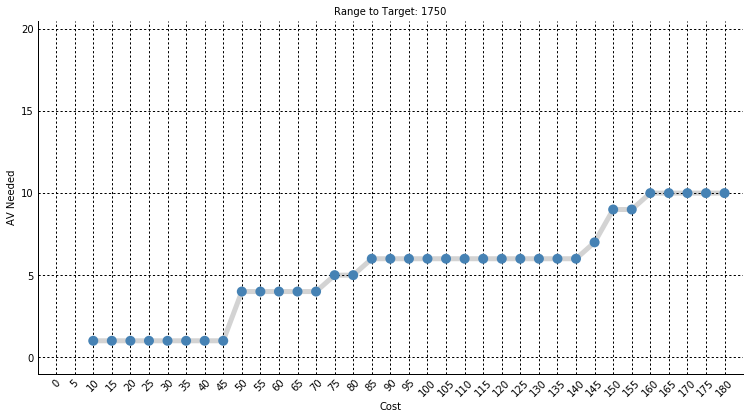
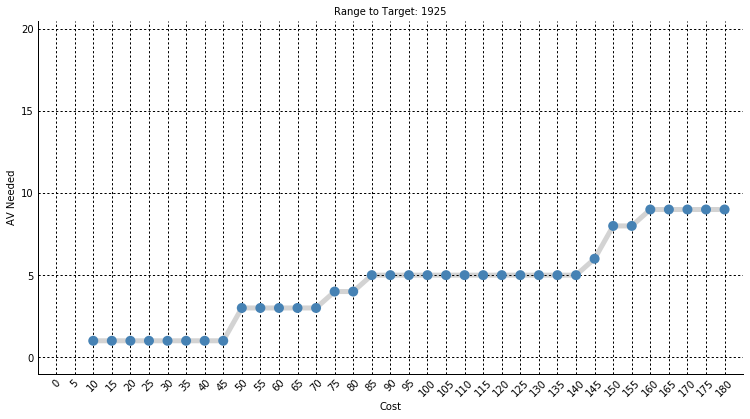
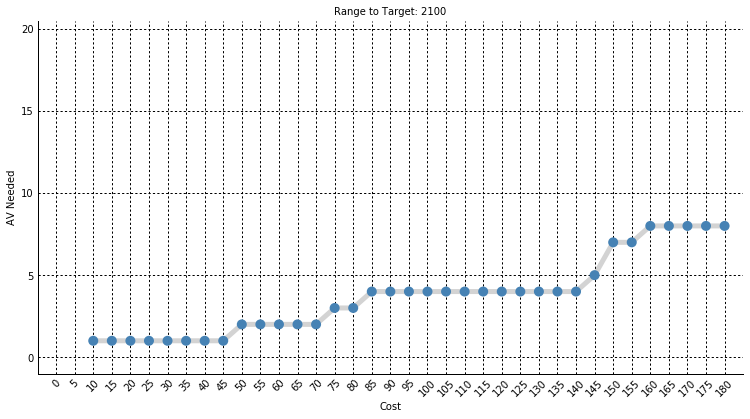
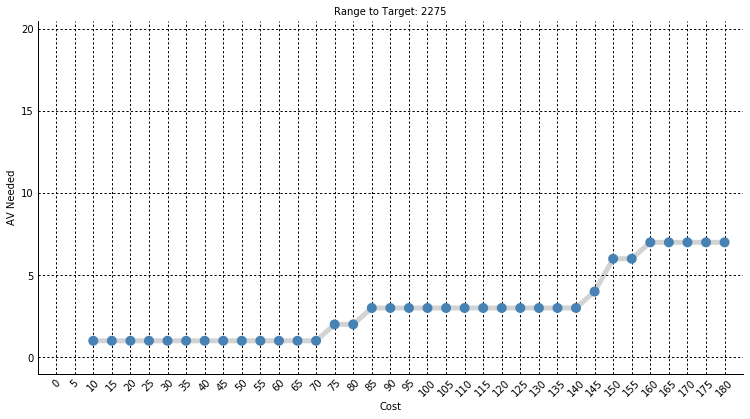

In [317]:
hv.HoloMap(blu_resist, kdims=['Range to Target'])

In [319]:
%%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=5 xticks=list(zip(np.linspace(180, 0, 37), np.linspace(180, 0, 37).astype(int))), xrotation=45] Scatter [show_grid=False]

red_resist = [(
            (dist), 
            (
                hv.Curve(hv.Table(avs_needed_to_resist(range=dist), 
                                    kdims=['Cost'], 
                                    vdims=['AV Needed']), 
                        extents=(-5, -1, 185, 20.5))(style={'color': 'lightgray', 'linewidth': 5}) *
                hv.Scatter(avs_needed_to_resist(range=dist))(style={'color': 'steelblue', 's': 100})              
            )
          ) for dist in np.linspace(2275, 0, 14)]

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use s

b':HoloMap   [Range to Target]\n   :Overlay\n      .Curve.I   :Curve   [Cost]   (AV Needed)\n      .Scatter.I :Scatter   [x]   (y)'
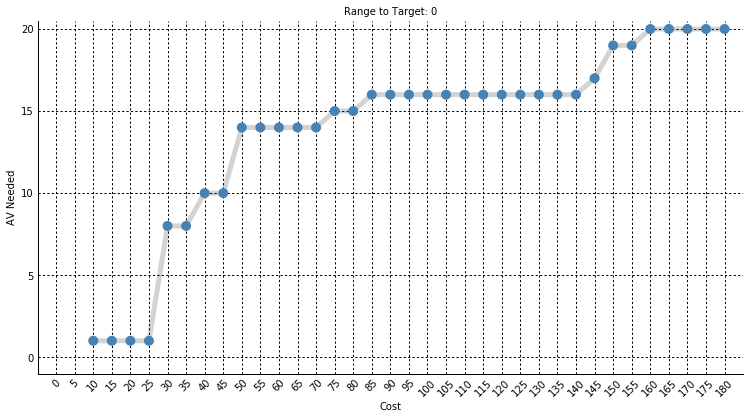
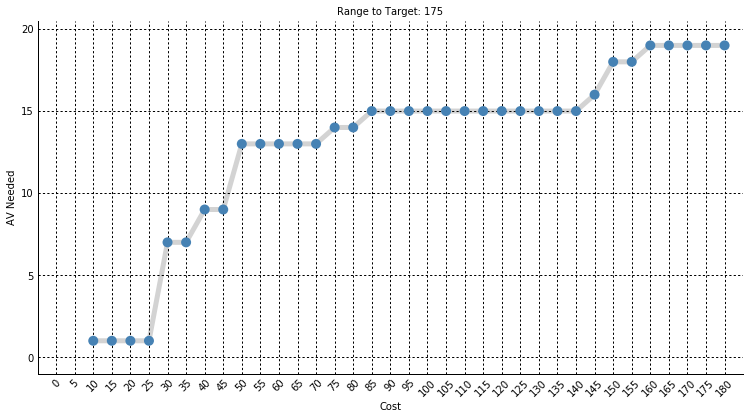
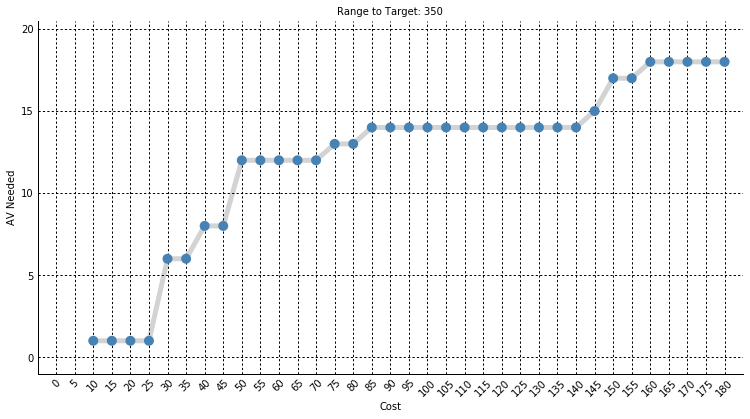
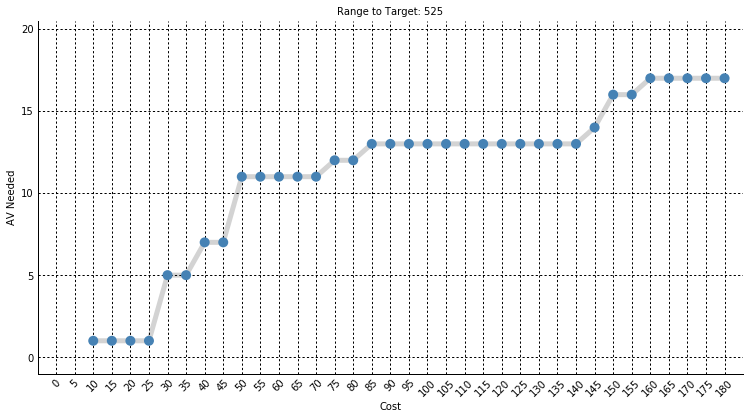
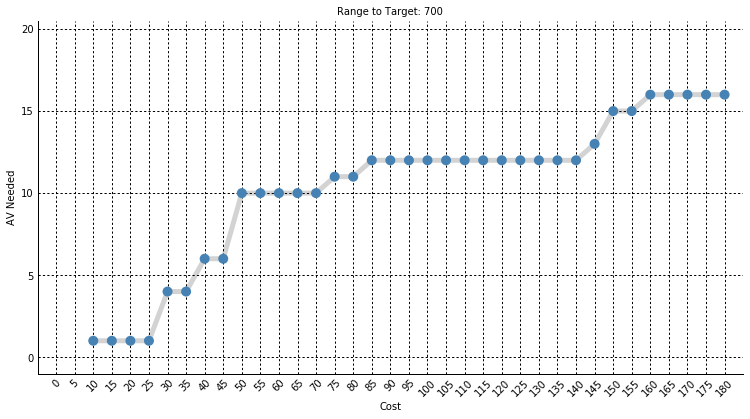
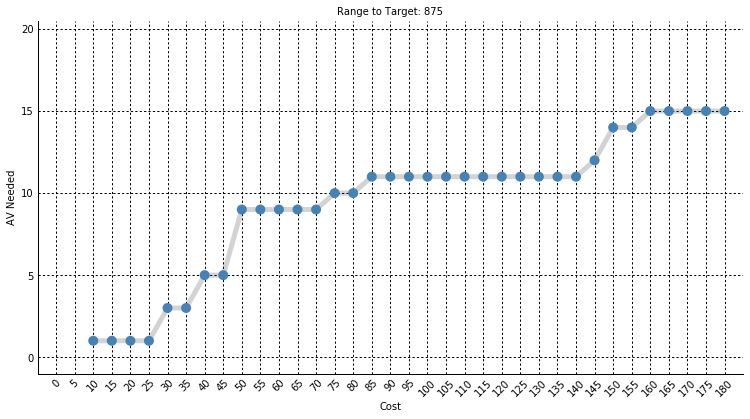
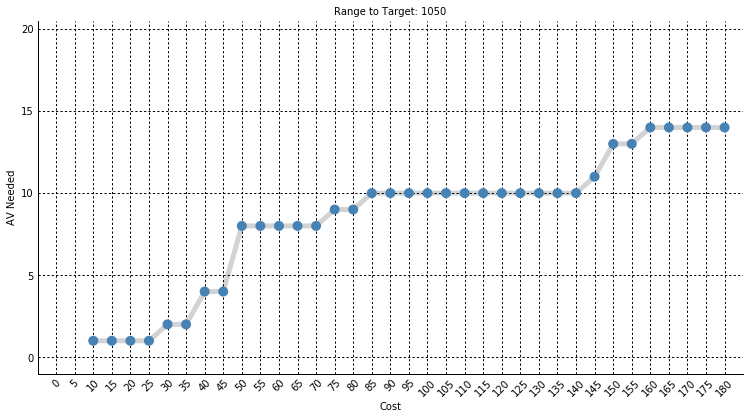
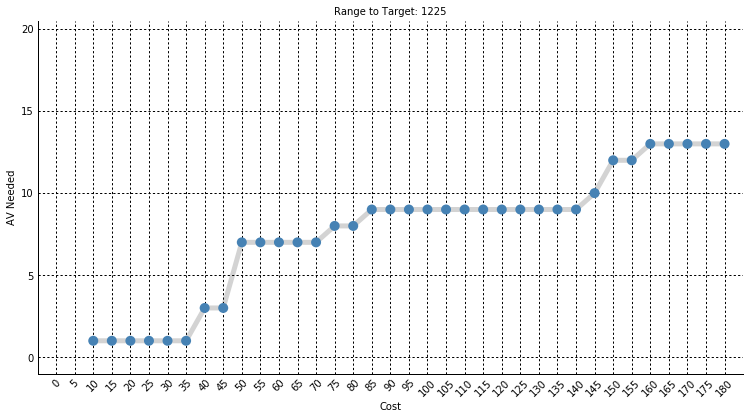
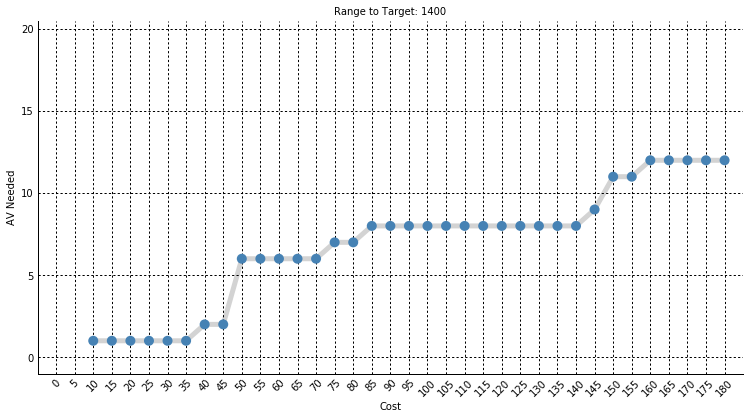
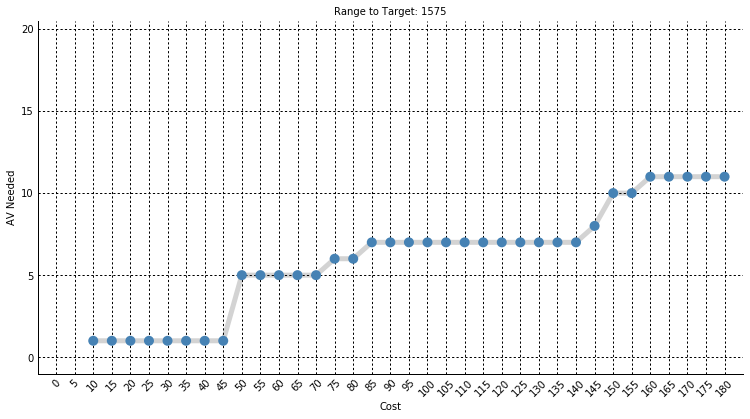
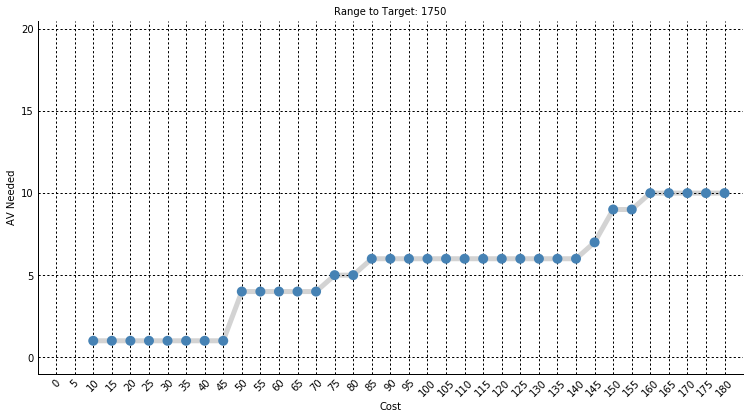
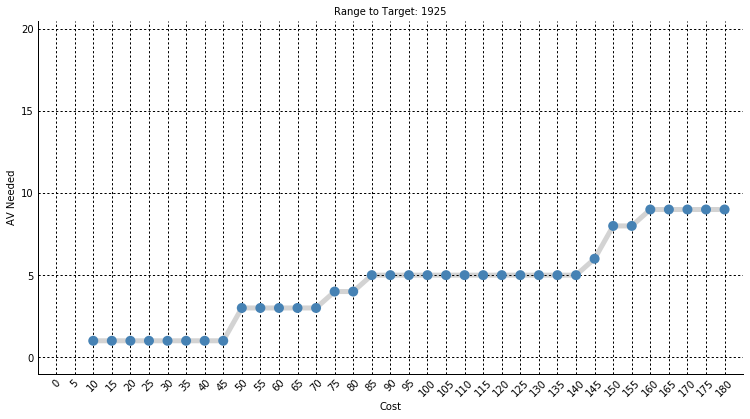
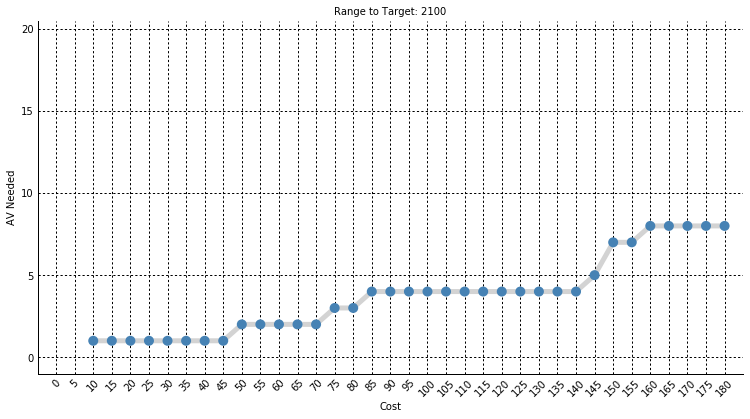
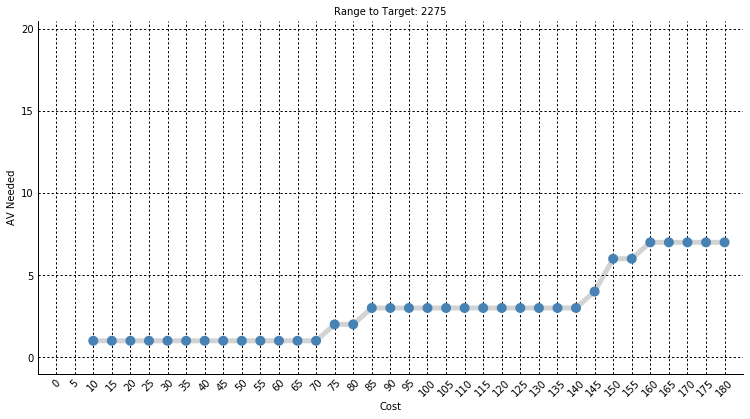

In [320]:
hv.HoloMap(red_resist, kdims=['Range to Target'])

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use s

b':HoloMap   [Range to Target]\n   :Overlay\n      .Curve.I   :Curve   [Cost]   (AV Needed)\n      .Scatter.I :Scatter   [x]   (y)'
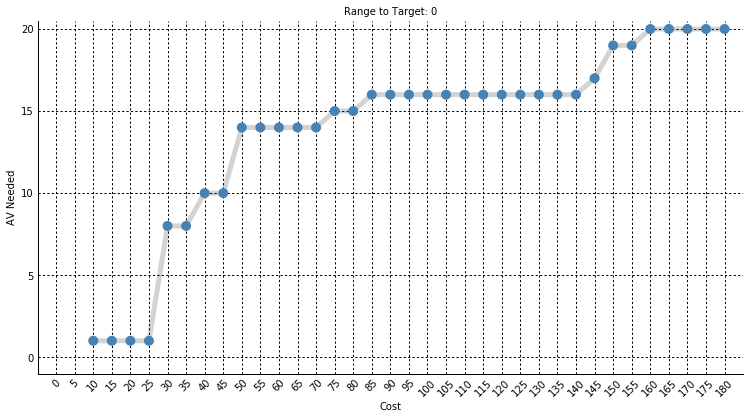
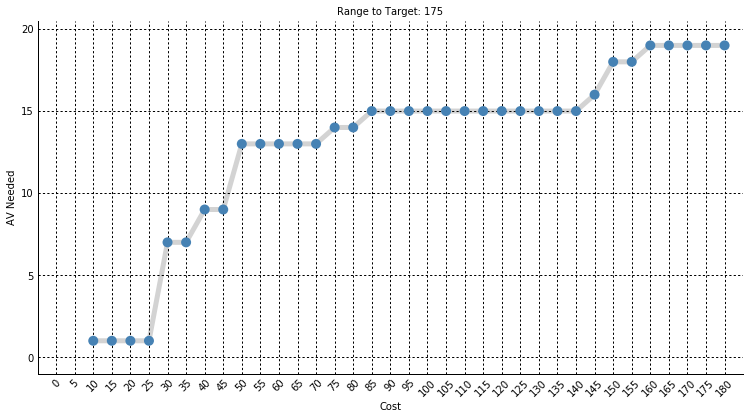
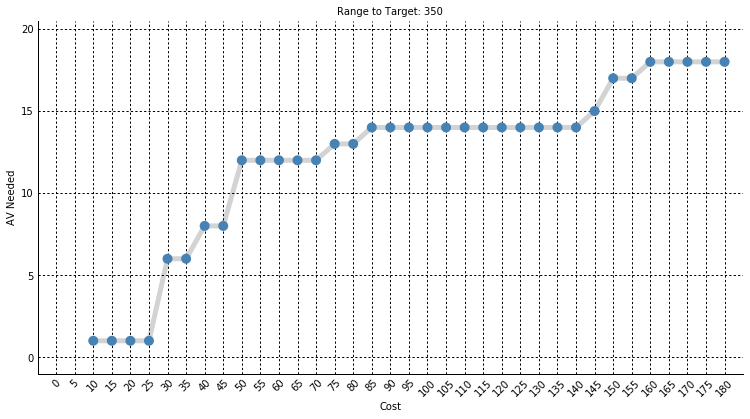
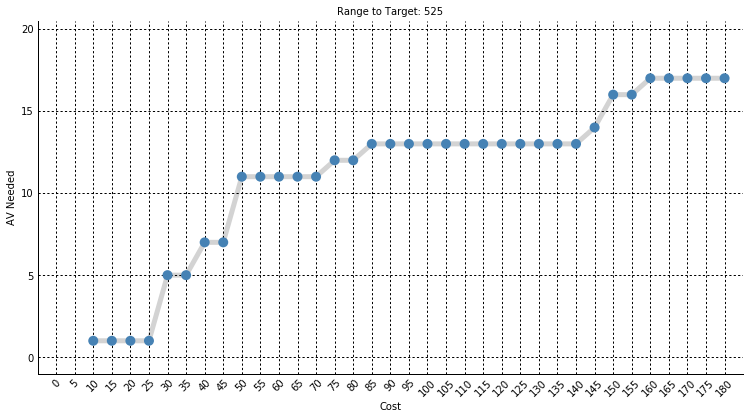
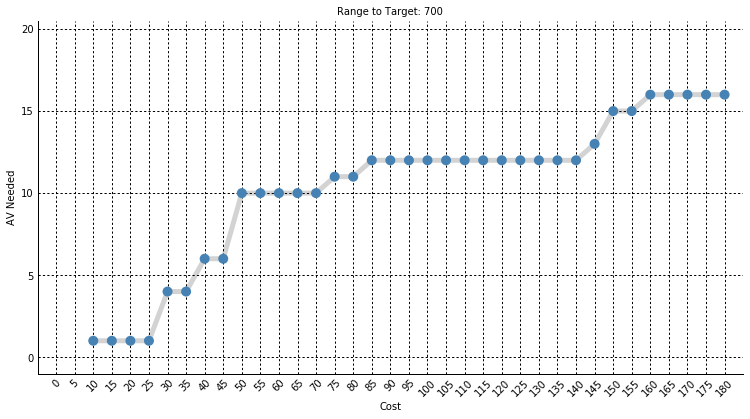
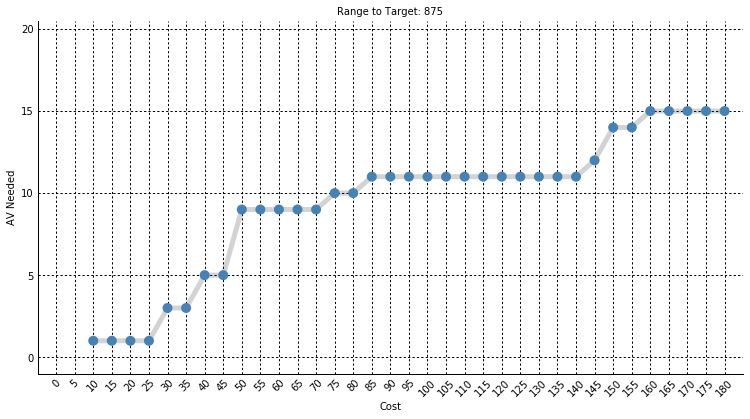
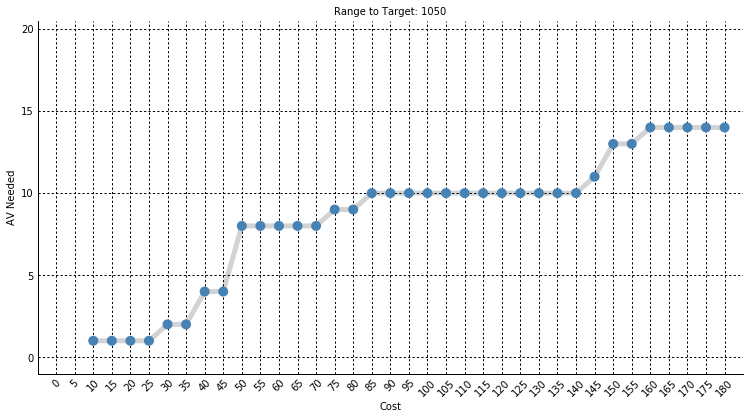
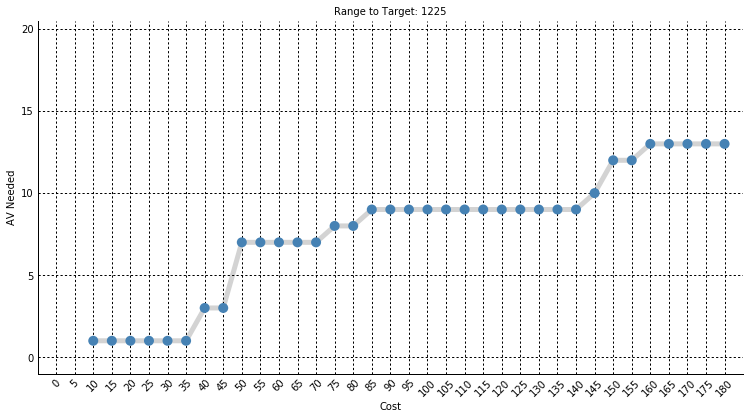
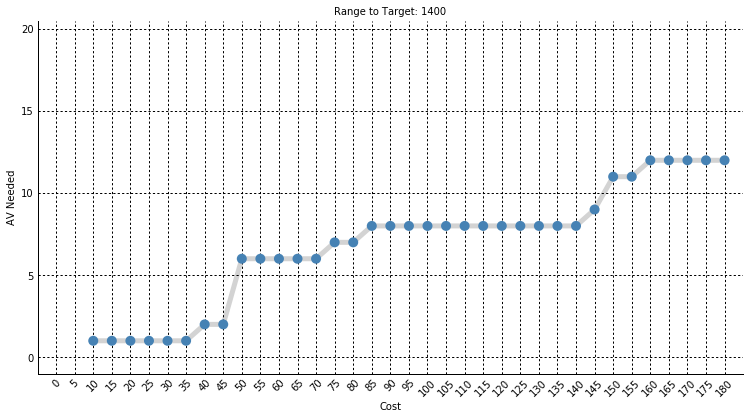
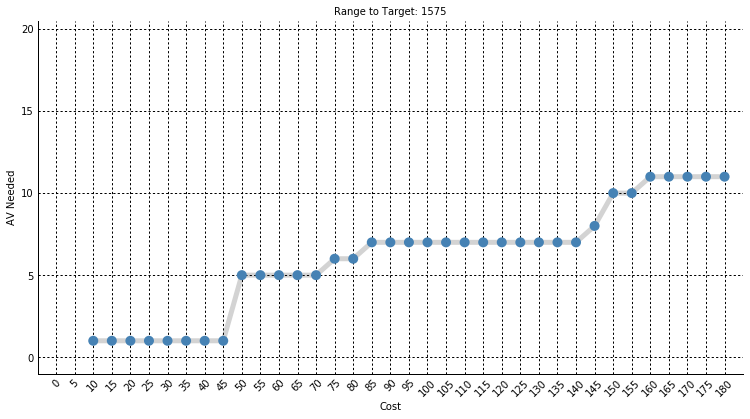
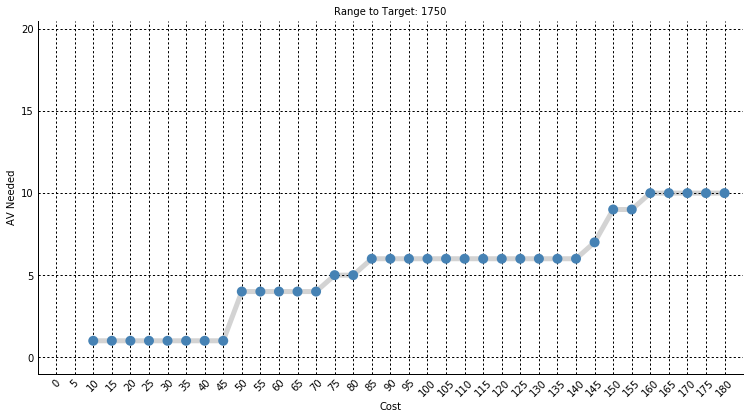
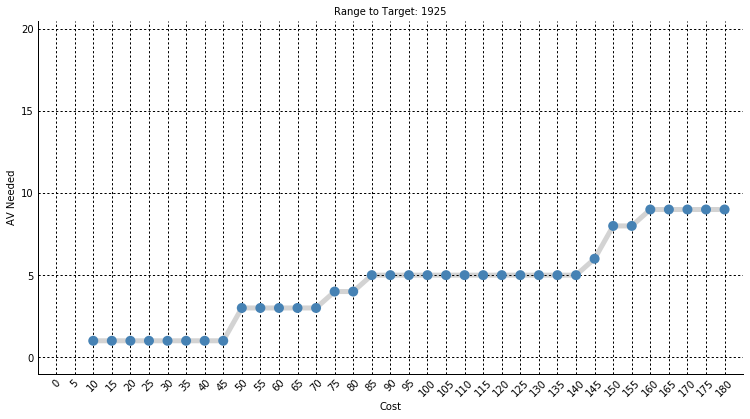
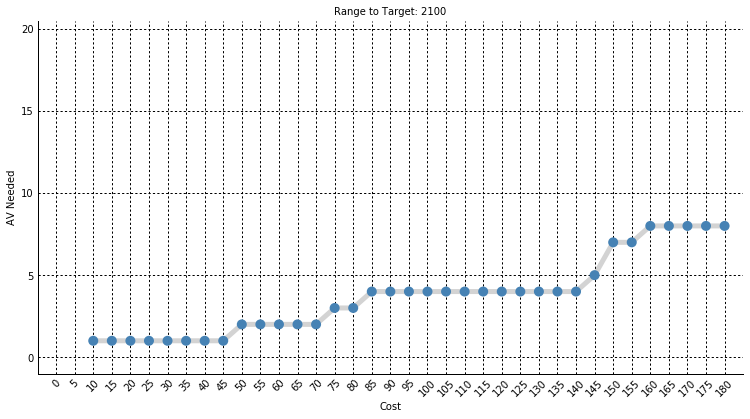
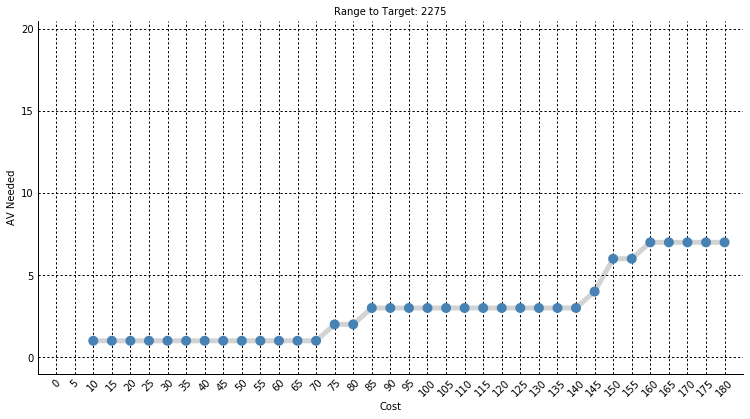

In [14]:
%%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=5 xticks=list(zip(np.linspace(180, 0, 37), np.linspace(180, 0, 37).astype(int))), xrotation=45] Scatter [show_grid=False]

blu_resist = []
for dist in np.linspace(2275, 0, 14):
    plot_obj = (hv.Curve(hv.Table(avs_needed_to_resist(range=dist), 
                                    kdims=['Cost'], 
                                    vdims=['AV Needed']), 
                        extents=(-5, -1, 185, 20.5))(style={'color': 'lightgray', 'linewidth': 5}) *
               hv.Scatter(avs_needed_to_resist(range=dist))(style={'color': 'steelblue', 's': 100}))
    blu_resist.append(((dist), plot_obj))

hv.HoloMap(blu_resist, kdims=['Range to Target'])

In [15]:
blu_resist

[(2275.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (2100.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1925.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1750.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1575.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1400.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1225.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (1050.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (875.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scatter.I :Scatter   [x]   (y)), (700.0, :Overlay
     .Curve.I   :Curve   [Cost]   (AV Needed)
     .Scat

In [17]:
resist

[:Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y), :Overlay
    .Curve.I   :Curve   [Cost]   (AV Needed)
    .Scatter.I :Scatter   [x]   (y)

In [63]:
%%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=21 xticks=list(zip(np.linspace(180, 5, 36), np.linspace(180, 5, 36).astype(int))), xrotation=45] Scatter [show_grid=False]

resist = []
for dist in np.linspace(2275, 0, 14):
    
    blu_avs = avs_needed_to_resist(range=dist, opfor='redfor')
    blu_table = hv.Table(blu_avs, kdims=['Cost'], vdims=['AV Needed'])
    
    red_avs = avs_needed_to_resist(range=dist, opfor='blufor')
    red_table = hv.Table(red_avs, kdims=['Cost'], vdims=['AV Needed'])
    
    plot_obj = (
        hv.Curve(blu_table, extents=(0, 0, 185, 20.5))(style={'color': 'lightsteelblue', 'linewidth': 5}) *
        hv.Curve(red_table, extents=(0, 0, 185, 20.5))(style={'color': '#ff8b8b', 'linewidth': 5}) *        
        hv.Scatter(blu_avs)(style={'color': 'steelblue', 's': 100}) *
        hv.Scatter(red_avs)(style={'color': 'darkred', 's': 100})        
    )
    resist.append(((dist), plot_obj))

/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  axis.set_axis_bgcolor(self.bgcolor)
/home/alex/miniconda3/envs/plotting-tools/lib/python3.6/site-packages/holoviews/plotting/mpl/element.py:152: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use s

b':HoloMap   [Range to Target]\n   :Overlay\n      .Curve.I    :Curve   [Cost]   (AV Needed)\n      .Curve.II   :Curve   [Cost]   (AV Needed)\n      .Scatter.I  :Scatter   [x]   (y)\n      .Scatter.II :Scatter   [x]   (y)'
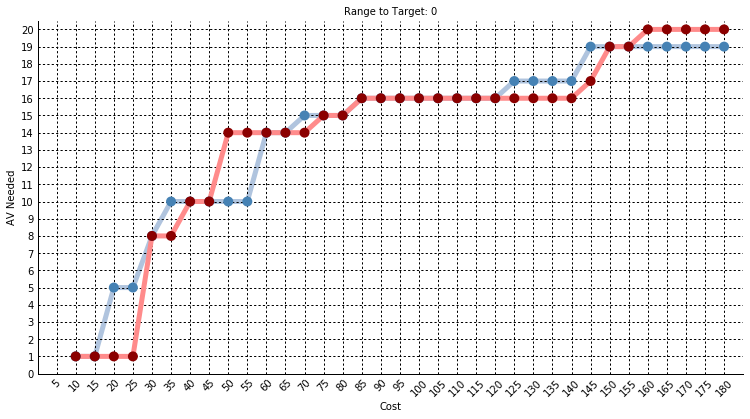
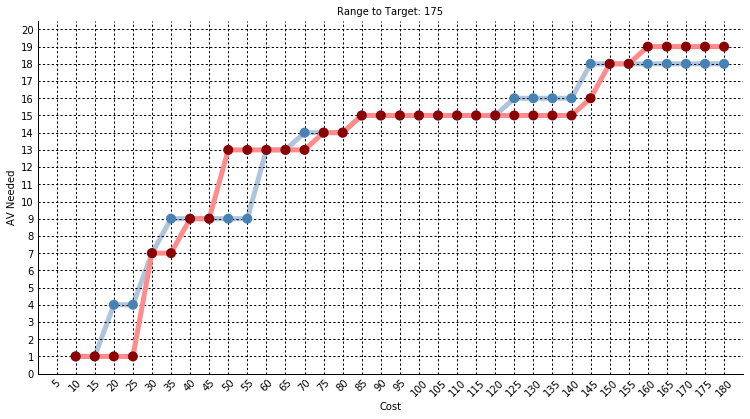
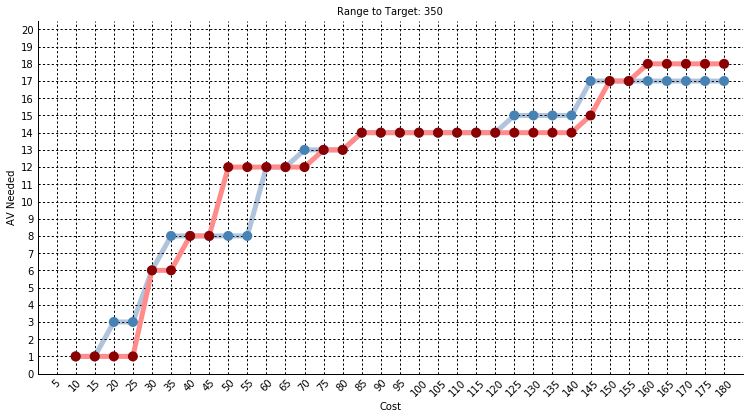
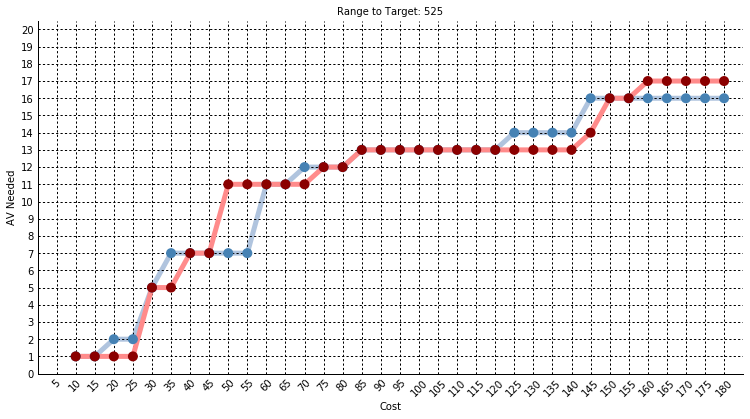
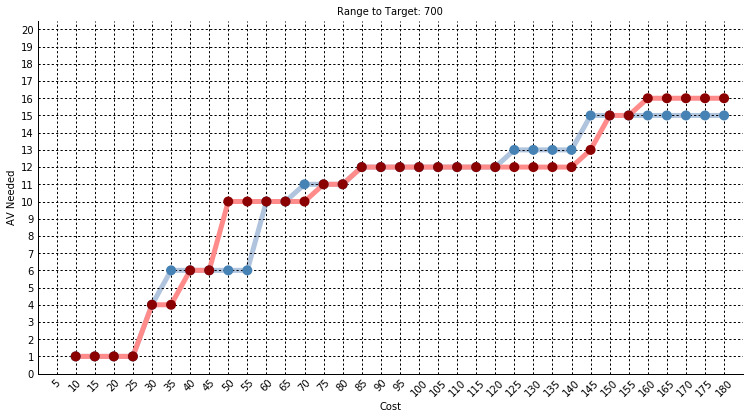
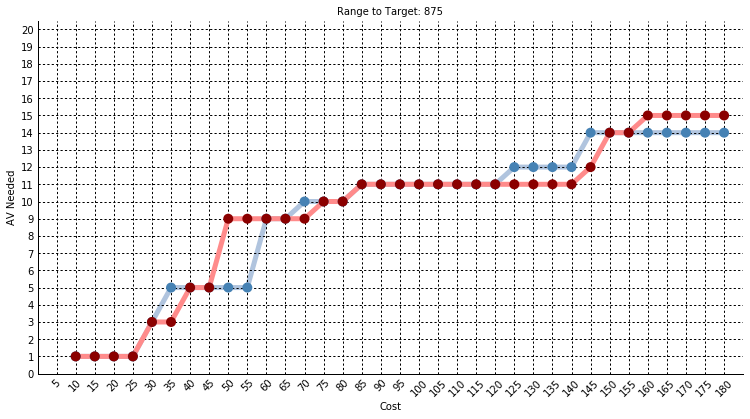
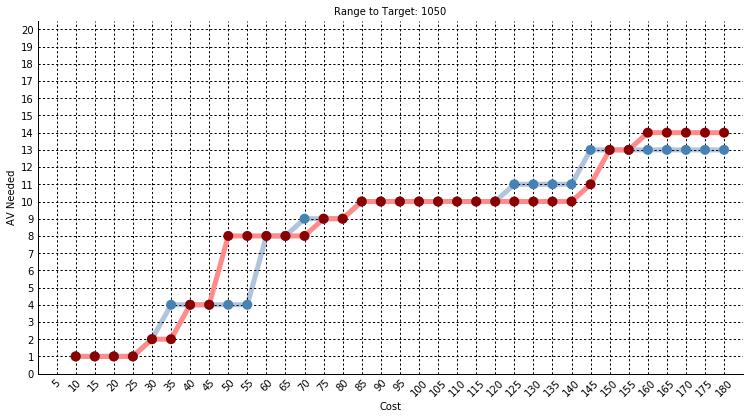
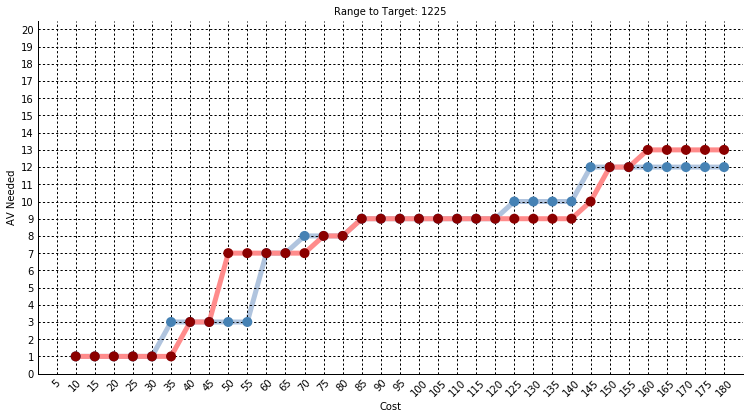
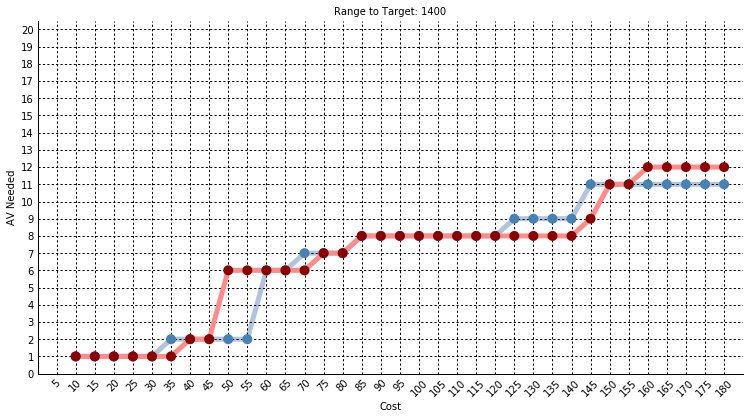
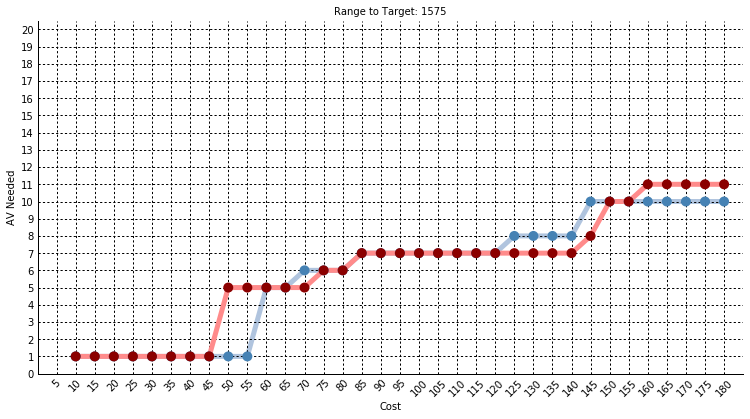
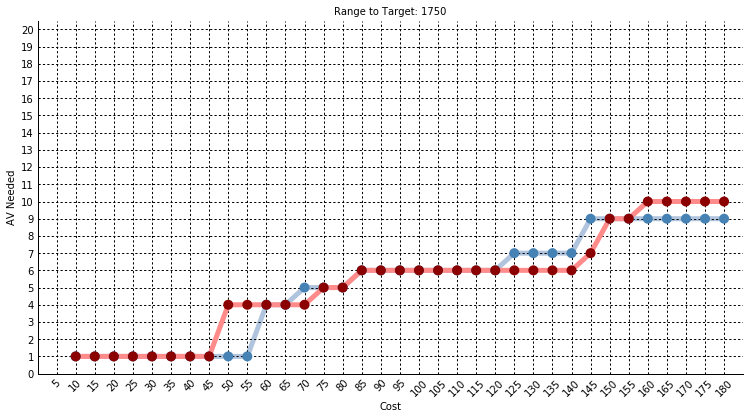
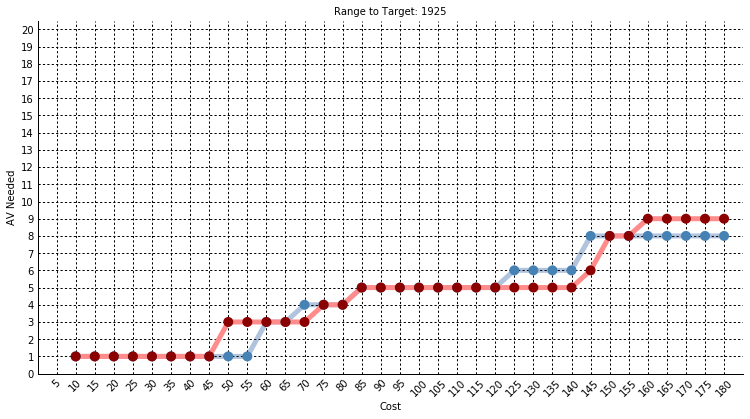
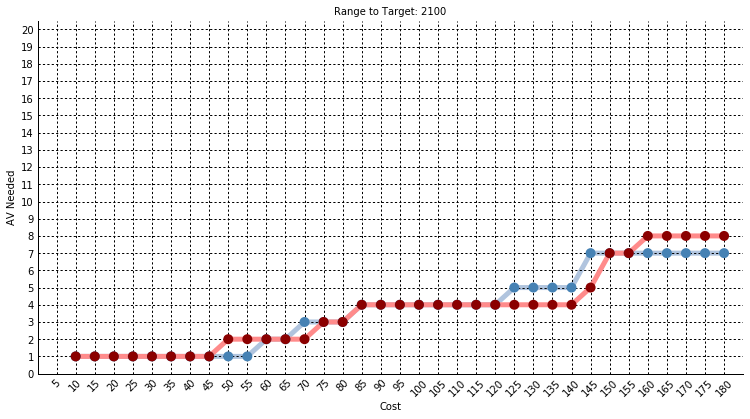
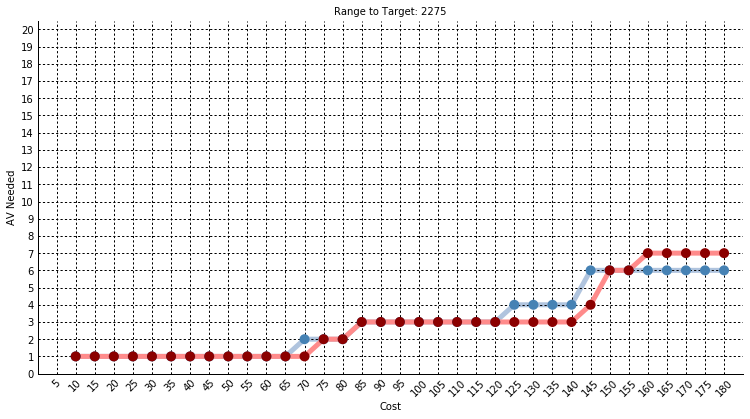

In [64]:
hv.HoloMap(resist, kdims=['Range to Target'])

In [68]:
# hv.notebook_extension('bokeh')
# Doesn't work in Bokeh out-of-the-box. Boo!

In [72]:
# %%opts Overlay [aspect=2 fig_size=350 show_frame=False bgcolor='white' yticks=21 xticks=list(zip(np.linspace(180, 5, 36), np.linspace(180, 5, 36).astype(int))), xrotation=45] Scatter [show_grid=False]

# resist = []
# for dist in np.linspace(2275, 0, 14):
    
#     blu_avs = avs_needed_to_resist(range=dist, opfor='redfor')
#     blu_table = hv.Table(blu_avs, kdims=['Cost'], vdims=['AV Needed'])
    
#     red_avs = avs_needed_to_resist(range=dist, opfor='blufor')
#     red_table = hv.Table(red_avs, kdims=['Cost'], vdims=['AV Needed'])
    
#     plot_obj = (
#         hv.Curve(blu_table, extents=(0, 0, 185, 20.5))(style={'color': 'lightsteelblue', 'linewidth': 5}) *
#         hv.Curve(red_table, extents=(0, 0, 185, 20.5))(style={'color': '#ff8b8b', 'linewidth': 5}) *        
#         hv.Scatter(blu_avs)(style={'color': 'steelblue', 's': 100}) *
#         hv.Scatter(red_avs)(style={'color': 'darkred', 's': 100})        
#     )
#     resist.append(((dist), plot_obj))